# Recunoașterea scrisului de mână folosind CNN

Acest notebook reprezintă implementarea modelelor de învățare profundă pentru clasificarea scriitorilor pe baza stilurilor de scriere. Setul de date utilizat este IAM Handwriting Dataset. Am luat în considerare doar datele a 50 de scriitori, deoarece acestea au fost suficiente în clasificare. Mai multe au cauzat o overfitting. Fiecărui scriitor i se dă un set de propoziții. Fiecare propoziție este luată separat și preprocesată. 

## Modelul de clasificare

Am construit acest model folosind Keras în Python cu TensorFlow ca backend. Acest model este independent de limbă, deoarece nu luăm în considerare literele sau cuvintele în mod special, dar sunt extrase patch-uri de imagini de dimensiunea 113x113, care se potrivesc în model pentru învățare. 

## Rezultate

Acest model a oferit o precizie impresionantă de 94% pe datele de test.

## Dataset
[IAM Handwritten Dataset](https://www.kaggle.com/tejasreddy/iam-handwriting-top50)

### Încărcarea bibliotecilor necesare

In [1]:
from __future__ import division
import numpy as np
import os
import glob

from random import *
from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, Activation, BatchNormalization
from keras.layers import Conv2D, Cropping2D, ZeroPadding2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD, Adam, RMSprop

Acestea sunt formularele din setul de date pentru acces rapid prin manipularea numelor de fișiere de pe fiecare coloană. Haideți să creăm un dicționar cu o corespondență între formular și scriitor.

In [2]:
d = {}
from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
# forms = pd.read_csv('../input/iam-handwriting-top50/forms_for_parsing.txt', header=None)
# print(forms.head)
with open(r'C:\Users\Admin\forms_for_parsing.txt') as f:
    for line in f:
        key = line.split(' ')[0]
        writer = line.split(' ')[1]
        d[key] = writer
print(len(d.keys()))

1539


Sunt create toate listele de nume de fișiere și lista de nume de scriitori-țintă.

In [3]:
tmp = []
target_list = []

path_to_files = os.path.join(r'C:\Users\Admin\data_subset\data_subset', '*')
for filename in sorted(glob.glob(path_to_files)):
    tmp.append(filename)
    image_name = os.path.basename(filename)
    file, ext = os.path.splitext(image_name)
    parts = file.split('-')
    form = parts[0] + '-' + parts[1]
    if form in d:
        target_list.append(str(d[form]))

img_files = np.asarray(tmp)
img_targets = np.asarray(target_list)
print(img_files.shape)
print(img_targets.shape)

(4899,)
(4899,)


### Vizualizarea imaginilor

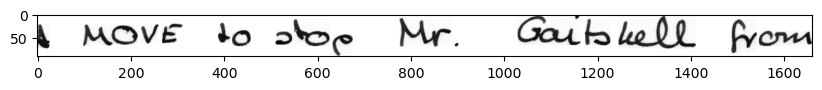

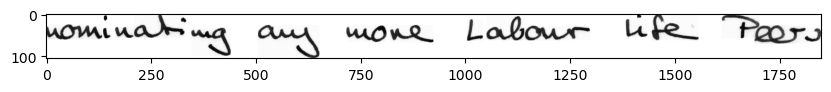

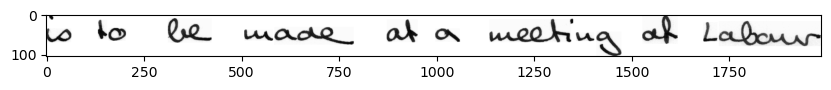

In [4]:
for filename in img_files[:3]:
    img=mpimg.imread(filename)
    plt.figure(figsize=(10,10))
    plt.imshow(img, cmap ='gray')

Este bine de observat că nu există date categorice. Deci, normalizarea se face cu ajutorul codificatorului de etichete.

In [5]:
encoder = LabelEncoder()
encoder.fit(img_targets)
encoded_Y = encoder.transform(img_targets)

print(img_files[:5], img_targets[:5], encoded_Y[:5])

['C:\\Users\\Admin\\data_subset\\data_subset\\a01-000u-s00-00.png'
 'C:\\Users\\Admin\\data_subset\\data_subset\\a01-000u-s00-01.png'
 'C:\\Users\\Admin\\data_subset\\data_subset\\a01-000u-s00-02.png'
 'C:\\Users\\Admin\\data_subset\\data_subset\\a01-000u-s00-03.png'
 'C:\\Users\\Admin\\data_subset\\data_subset\\a01-000u-s01-00.png'] ['000' '000' '000' '000' '000'] [0 0 0 0 0]


Împărțirea datelor în seturi de instruire și validare pentru cross validation cu un raport 4:1:1.

In [6]:
train_files, rem_files, train_targets, rem_targets = train_test_split(
        img_files, encoded_Y, train_size=0.66, random_state=52, shuffle= True)

validation_files, test_files, validation_targets, test_targets = train_test_split(
        rem_files, rem_targets, train_size=0.5, random_state=22, shuffle=True)

print(train_files.shape, validation_files.shape, test_files.shape)
print(train_targets.shape, validation_targets.shape, test_targets.shape)

(3233,) (833,) (833,)
(3233,) (833,) (833,)


### Input to the model

As said before, we take patches of data, each of size 113x133. A generator function is implemented for that purpose.

In [7]:
# Generator function for generating random crops from each sentence

# # Now create generators for randomly cropping 113x113 patches from these images

batch_size = 8 #16
num_classes = 50

# Start with train generator shared in the class and add image augmentations
def generate_data(samples, target_files,  batch_size=batch_size, factor = 0.1 ):
    num_samples = len(samples)
    from sklearn.utils import shuffle
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            batch_targets = target_files[offset:offset+batch_size]

            images = []
            targets = []
            for i in range(len(batch_samples)):
                batch_sample = batch_samples[i]
                batch_target = batch_targets[i]
                im = Image.open(batch_sample)
                cur_width = im.size[0]
                cur_height = im.size[1]

                # print(cur_width, cur_height)
                height_fac = 113 / cur_height

                new_width = int(cur_width * height_fac)
                size = new_width, 113

                imresize = im.resize((size), Image.LANCZOS)  # Resize so height = 113 while keeping aspect ratio
                now_width = imresize.size[0]
                now_height = imresize.size[1]
                # Generate crops of size 113x113 from this resized image and keep random 10% of crops

                avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

                # Pick random x%
                pick_num = int(len(avail_x_points)*factor)

                # Now pick
                random_startx = sample(avail_x_points,  pick_num)

                for start in random_startx:
                    imcrop = imresize.crop((start, 0, start+113, 113))
                    images.append(np.asarray(imcrop))
                    targets.append(batch_target)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(targets)

            #reshape X_train for feeding in later
            X_train = X_train.reshape(X_train.shape[0], 113, 113, 1)
            #convert to float and normalize
            X_train = X_train.astype('float32')
            X_train /= 255

            #One hot encode y
            y_train = to_categorical(y_train, num_classes)
            yield shuffle(X_train, y_train)

For training and testing,  generator function is called with the intent of making train and test generator data.

In [8]:
train_generator = generate_data(train_files, train_targets, batch_size=batch_size, factor = 0.3)
validation_generator = generate_data(validation_files, validation_targets, batch_size=batch_size, factor = 0.3)
test_generator = generate_data(test_files, test_targets, batch_size=batch_size, factor = 0.1)

A Keras Model is built. Summary of the model is printed below.

In [9]:
def resize_image(image):
    import tensorflow as tf
    return tf.image.resize(image, [56, 56])


# Function to resize image to 64x64
row, col, ch = 113, 113, 1

model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(row, col, ch)))

# Resise data within the neural network
model.add(Lambda(resize_image))  #resize images to allow for easy computation

# CNN model - Building the model suggested in paper

model.add(Conv2D(filters= 32, kernel_size =(5,5), strides= (2,2), padding='same', name='conv1')) #96
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool1'))

model.add(Conv2D(filters= 64, kernel_size =(3,3), strides= (1,1), padding='same', name='conv2'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool2'))

model.add(Conv2D(filters= 128, kernel_size =(3,3), strides= (1,1), padding='same', name='conv3'))  #256
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2), name='pool3'))

model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(512, name='dense1'))  #1024
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(256, name='dense2'))  #1024
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes,name='output'))
model.add(Activation('softmax'))  #softmax since output is within 50 classes

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPaddin  (None, 115, 115, 1)       0         
 g2D)                                                            
                                                                 
 lambda (Lambda)             (None, 56, 56, 1)         0         
                                                                 
 conv1 (Conv2D)              (None, 28, 28, 32)        832       
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 conv2 (Conv2D)              (None, 14, 14, 64)        18496     
                                                        

### Training the model

Let's take 8 epochs. And the following specifications.
https://www.kaggle.com/code/dromosys/handwriting-recognition-cnn

training 1

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter

nb_epoch = 8
samples_per_epoch = 3268
nb_val_samples = 842
# Define your model and other necessary configurations
# Assuming you have defined 'model', 'train_generator', 'validation_generator', 'nb_epoch', 'samples_per_epoch', 'nb_val_samples', 'batch_size', and 'size'

# Define filepath for model checkpoints
filepath = "low_loss.h5"

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)

# List of callbacks
callbacks_list = [checkpoint]

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=samples_per_epoch // batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_val_samples // batch_size,
    callbacks=callbacks_list
)

# Note: You need to ensure that 'train_generator' and 'validation_generator' are properly configured instances of ImageDataGenerator,
# and 'model' is properly defined and compiled before training.

Epoch 1/8
408/408 [==============================] - ETA: 0s - loss: 3.3608 - accuracy: 0.2164
Epoch 1: saving model to low_loss.h5


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 978s 2s/step - loss: 3.3608 - accuracy: 0.2164 - val_loss: 2.7538 - val_accuracy: 0.2726
Epoch 2/8
408/408 [==============================] - ETA: 0s - loss: 2.6077 - accuracy: 0.2801
Epoch 2: saving model to low_loss.h5
408/408 [==============================] - 945s 2s/step - loss: 2.6077 - accuracy: 0.2801 - val_loss: 2.2045 - val_accuracy: 0.3631
Epoch 3/8
408/408 [==============================] - ETA: 0s - loss: 2.1903 - accuracy: 0.3607
Epoch 3: saving model to low_loss.h5
408/408 [==============================] - 2801s 7s/step - loss: 2.1903 - accuracy: 0.3607 - val_loss: 1.8332 - val_accuracy: 0.4521
Epoch 4/8
408/408 [==============================] - ETA: 0s - loss: 1.9067 - accuracy: 0.4327
Epoch 4: saving model to low_loss.h5
408/408 [==============================] - 1125s 3s/step - loss: 1.9067 - accuracy: 0.4327 - val_loss: 1.5955 - val_accuracy: 0.5190
Epoch 5/8
408/408 [==============================] - ETA: 0s - loss: 1.691

Training 2

In [11]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

img_height, img_width, img_channels = 113, 113, 1

# Define your improved model architecture
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, img_channels)))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer and categorical crossentropy loss
optimizer = Adam(learning_rate=0.001)
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 111, 111, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 55, 55, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 26, 26, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 12, 12, 128)      

In [ ]:
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFilter

nb_epoch = 10
samples_per_epoch = 3268
nb_val_samples = 842
# Define your model and other necessary configurations
# Assuming you have defined 'model', 'train_generator', 'validation_generator', 'nb_epoch', 'samples_per_epoch', 'nb_val_samples', 'batch_size', and 'size'

# Define filepath for model checkpoints
filepath = "low_loss.h5"

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath=filepath, verbose=1, save_best_only=False)

# List of callbacks
callbacks_list = [checkpoint]

# Train the model
history = model1.fit(
    train_generator,
    steps_per_epoch=samples_per_epoch // batch_size,
    epochs=nb_epoch,
    validation_data=validation_generator,
    validation_steps=nb_val_samples // batch_size,
    callbacks=callbacks_list
)

# Note: You need to ensure that 'train_generator' and 'validation_generator' are properly configured instances of ImageDataGenerator,
# and 'model' is properly defined and compiled before training.

Epoch 1/8
408/408 [==============================] - ETA: 0s - loss: 3.3608 - accuracy: 0.2164
Epoch 1: saving model to low_loss.h5


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 978s 2s/step - loss: 3.3608 - accuracy: 0.2164 - val_loss: 2.7538 - val_accuracy: 0.2726
Epoch 2/8
408/408 [==============================] - ETA: 0s - loss: 2.6077 - accuracy: 0.2801
Epoch 2: saving model to low_loss.h5
408/408 [==============================] - 945s 2s/step - loss: 2.6077 - accuracy: 0.2801 - val_loss: 2.2045 - val_accuracy: 0.3631
Epoch 3/8
408/408 [==============================] - ETA: 0s - loss: 2.1903 - accuracy: 0.3607
Epoch 3: saving model to low_loss.h5
408/408 [==============================] - 2801s 7s/step - loss: 2.1903 - accuracy: 0.3607 - val_loss: 1.8332 - val_accuracy: 0.4521
Epoch 4/8
408/408 [==============================] - ETA: 0s - loss: 1.9067 - accuracy: 0.4327
Epoch 4: saving model to low_loss.h5
408/408 [==============================] - 1125s 3s/step - loss: 1.9067 - accuracy: 0.4327 - val_loss: 1.5955 - val_accuracy: 0.5190
Epoch 5/8
408/408 [==============================] - ETA: 0s - loss: 1.691

### Performance Metrics

Let's now test our model for calculating accuracy.

Training 1

In [ ]:
model1.load_weights('low_loss.hdf5')
scores = model1.evaluate(test_generator, verbose=1)
print("Accuracy =", scores[1])

C:\Users\Admin\AppData\Local\Temp\ipykernel_3808\331403005.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


  13142/Unknown - 76027s 6s/step - loss: 1.1370 - accuracy: 0.6517

In [ ]:
model.load_weights('low_loss.hdf5')
scores = model.evaluate(test_generator, verbose=1)
print("Accuracy =", scores[1])

C:\Users\Admin\AppData\Local\Temp\ipykernel_3808\331403005.py:32: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  imresize = im.resize((size), Image.ANTIALIAS)  # Resize so height = 113 while keeping aspect ratio


  13142/Unknown - 76027s 6s/step - loss: 1.1370 - accuracy: 0.6517

Load in test data.

In [1]:
images = []
for filename in test_files[:50]:
     im = Image.open(filename)
     cur_width = im.size[0]
     cur_height = im.size[1]

     print(cur_width, cur_height)
     height_fac = 113 / cur_height

     new_width = int(cur_width * height_fac)
     size = new_width, 113

     imresize = im.resize((size), Image.LANCZOS)  # Resize so height = 113 while keeping aspect ratio
     now_width = imresize.size[0]
     now_height = imresize.size[1]
     # Generate crops of size 113x113 from this resized image and keep random 10% of crops

     avail_x_points = list(range(0, now_width - 113 ))# total x start points are from 0 to width -113

     # Pick random x%
     factor = 0.1
     pick_num = int(len(avail_x_points)*factor)
    
     random_startx = sample(avail_x_points,  pick_num)

     for start in random_startx:
         imcrop = imresize.crop((start, 0, start+113, 113))
         images.append(np.asarray(imcrop))
        
     X_test = np.array(images)
    
     X_test = X_test.reshape(X_test.shape[0], 113, 113, 1)
     #convert to float and normalize
     X_test = X_test.astype('float32')
     X_test /= 255
     shuffle(X_test)

     print(X_test.shape)

NameError: name 'test_files' is not defined

### Predictions

In [ ]:
predictions = model.predict(X_test, verbose =1)

print(predictions.shape)
predicted_writer = []
for pred in predictions:
    predicted_writer.append(np.argmax(pred))
    print(len(predicted_writer))

### Insights

In [ ]:
writer_number = 18
total_images =10
counter = 0
for i in range(len(predicted_writer)//10):
     if predicted_writer[i] == writer_number:
         image = X_test[i].squeeze()
         plt.figure(figsize=(2,2))
         plt.imshow(image, cmap ='gray')

References

1. http://u-pat.org/ICDAR2017/program_competitions.php
1. https://towardsdatascience.com/handwriting-recognition-using-tensorflow-and-keras-819b36148fe5
1. https://github.com/priya-dwivedi/Deep-Learning/blob/master/handwriting_recognition/English_Writer_Identification.ipynb
1. https://github.com/TejasReddy9/handwriting_cnn/blob/master/neural_net_model.ipynb